In [1]:
from qiskit import *
import qiskit
import numpy as np
from numpy import pi

In [16]:
detuning = 3
signal_strength = 2
dt = 0.3
Gamma = 0.5

theta = 2 * np.arcsin(np.sqrt(Gamma * dt))

z_arg = -detuning * dt / 2
y_arg = -signal_strength * dt

qreg_q = QuantumRegister(2, "q")
creg_c = ClassicalRegister(1, "c")

qc = QuantumCircuit(qreg_q, creg_c)

for _ in range(1000):
    qc.u(z_arg, y_arg, z_arg, qreg_q[0])

    qc.cu(theta, 0, 0, 0, qreg_q[0], qreg_q[1])
    qc.cx(qreg_q[1], qreg_q[0])
    qc.measure(qreg_q[1], creg_c[0])
    qc.reset(qreg_q[1])

# qc.measure_all()

# qc.draw(fold=100)


In [17]:
from qiskit.providers.aer import QasmSimulator

backend = QasmSimulator()

qc_compiled = transpile(qc, backend)

job_sim = backend.run(qc_compiled, shots=8192)

In [18]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

qpt_circs = state_tomography_circuits(qc, qreg_q[0])
# qpt_tomo = ProcessTomographyFitter(job_sim.result(), qpt_circs)

# Execute
job = qiskit.execute(qpt_circs, Aer.get_backend('qasm_simulator'), shots=5000)

# Fit result
tomo_fitter = StateTomographyFitter(job.result(), qpt_circs)

In [19]:
fit = tomo_fitter.fit()
from qutip import Qobj

state = Qobj(fit)
state

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.95700385+0.j         0.00736782-0.20271456j]
 [0.00736782+0.20271456j 0.04299615+0.j        ]]

(<matplotlib.contour.QuadContourSet at 0x141f067e910>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

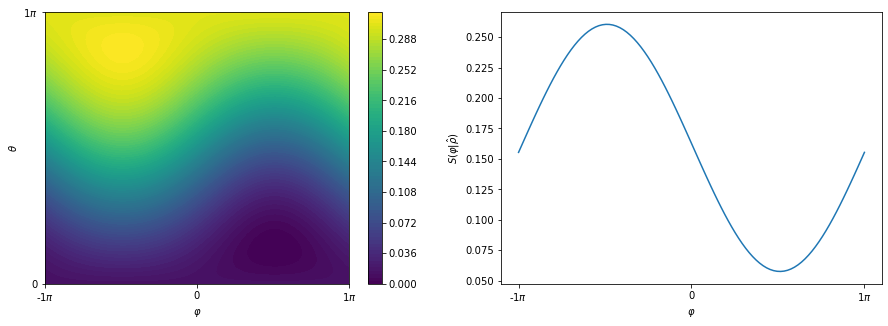

In [20]:
from sync_calcs import spin_husimi_qfunc, spin_S_measure
from sync_plots import plot_Q_and_S

n = 50

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)

Q = spin_husimi_qfunc(state, theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

In [21]:
# from qiskit.visualization import plot_histogram

# result_sim = job_sim.result()
# result_sim.get_counts()

# # Plot counts just for main qubit
# counts = result_sim.get_counts()
# counts = {"0": counts["00 0"] + counts["00 1"], "1": counts["01 0"]}

# plot_histogram(counts)

In [22]:
import qiskit.tools.jupyter
%qiskit_version_table